# Задание 1

![](img.png)

In [1]:
import numpy as np
import scipy.stats as sps
import scipy.integrate as spi
import scipy

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

%matplotlib inline

## Генерация выборки

In [2]:
def generate_sample(size: int = 1) -> np.array:
    sample = []
    
    for _ in range(size):
        x1, x2, x3, x4, x5 = np.random.uniform(-1, 1, 5)
        y = np.random.normal(2 + 3*x1 - 2*x2 + x3 + x4 - x5, 1.5, 1)[0]
        sample.append([x1, x2, x3, x4, x5, y])
    
    return np.array(sample)

In [3]:
samples = generate_sample(50)

## Нахождение коэффициентов регрессии

In [4]:
class LinearRegression:
    
    def __init__(self, factors: np.array, answers: np.array):
        self.factors = factors
        self.answers = answers
        
        self.F = factors.T @ factors
        self.inv_F = np.linalg.inv(self.F)
        self.coefficients = self.inv_F @ factors.T @ answers
        self.errors = self.answers - self.factors @ self.coefficients
        
        self.RSS = self.errors.T @ self.errors
        self.TSS = np.sum((self.answers - np.average(self.answers)) ** 2)
        self.R_square = (self.TSS - self.RSS) / self.TSS
    
    def is_regression_significant(self):
        delta = self.R_square / (1 - self.R_square) * (self.n - self.factors_count) / (self.factors_count - 1)
        p_value = spi.quad(sps.f.pdf, delta, np.inf, args=(self.factors_count - 1, self.n - self.factors_count))[0]
        return p_value < 0.05
    
    def check_multicollinearity(self):
        R_squares = []
        for i in range(1, self.factors_count):
            temp_factors = np.delete(self.factors, i, 1)
            temp_answers = self.factors[:, i]
            
            R_squares.append(LinearRegression(temp_factors, temp_answers).R_square)
        return R_squares

    def check_significant(self):
        p_values = []
        for i, coefficient in enumerate(self.coefficients):
            delta = coefficient / np.sqrt(self.RSS * self.inv_F[i][i]) * np.sqrt(self.n - self.factors_count)
            p_value = 2 * spi.quad(sps.t.pdf, delta, np.inf, args=(44,))[0]
            p_values.append(p_value)
        
        return p_values

    def cross_validation(self) -> (float, float):
        CVSS = []
        for i in range(self.n):
            temp_factors = np.delete(self.factors, i, 0)
            temp_answers = np.delete(self.answers, i, 0)
            temp_regression = LinearRegression(temp_factors, temp_answers)
            
            factor = self.factors[i]
            est_answer = factor @ temp_regression.coefficients
            CVSS.append((self.answers[i] - est_answer) ** 2)
        
        # average_answer = np.average(self.answers)
        TSS = np.sum((self.answers - np.average(self.answers)) ** 2)
        cvss = np.sum(CVSS)
        return cvss, (TSS - cvss) / TSS

    def scale_coefficients(self):
        new_coefficients = []
        for coefficient in self.coefficients:
            new_coefficients.append((coefficient - np.min(self.coefficients)) / 
                                    (np.max(self.coefficients) - np.min(self.coefficients)))
        return new_coefficients
    
    @property
    def n(self):
        return len(self.factors)
    
    @property
    def factors_count(self):
        return self.factors.shape[1]
    
    def __str__(self):
        return (f'Коэффициенты регрессии: {list(self.coefficients)}' + 
                f'\nRSS регрессии: {self.RSS}' + 
                f'\nTSS регрессии: {self.TSS}' +
                f'\nR^2 регрессии: {self.R_square}' +
                f'\nРегрессия значима: {"да" if self.is_regression_significant() else "нет"}')

In [5]:
all_factors = np.array([np.append(np.array([1]), sample[:5]) for sample in samples])
all_answers = samples[:, 5]

all_regression = LinearRegression(all_factors, all_answers)
print(str(all_regression))

Коэффициенты регрессии: [1.9175267126655315, 3.0224931693445427, -2.205475701383939, 0.12319308111107524, 1.0964934091321867, -0.883874557244291]
RSS регрессии: 96.17594514987245
TSS регрессии: 282.44361153841805
R^2 регрессии: 0.6594862081460441
Регрессия значима: да


## Проверка мультиколлинеарности

In [6]:
multicollinearity = all_regression.check_multicollinearity()
for i, coefficient in enumerate(multicollinearity, 1):
    print(f"Коэффициент {i} - R^2 = {coefficient:.4f}")

Коэффициент 1 - R^2 = 0.0961
Коэффициент 2 - R^2 = 0.2646
Коэффициент 3 - R^2 = 0.0725
Коэффициент 4 - R^2 = 0.2578
Коэффициент 5 - R^2 = 0.0311


In [7]:
significants = all_regression.check_significant()
print('P_value коэффициентов', significants)

P_value коэффициентов [1.6013689237760187e-10, 7.833284327707431e-10, 1.9999772257596864, 0.7320342951104464, 0.01244064211018664, 1.9856846098951535]


## Исследуем выборку на выбросы 

<AxesSubplot:>

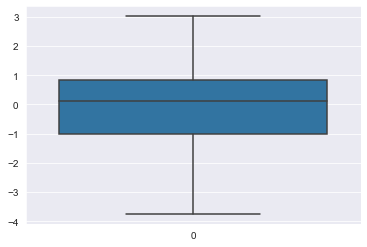

In [8]:
sns.boxplot(data=all_regression.errors)

Выбросов нет, поэтому мы берем, находим min и max и удаляем их, а дальше вновь строим регрессию и смотрим на все

In [9]:
min_index = np.where(all_regression.errors == np.min(all_regression.errors))[0][0]
max_index = np.where(all_regression.errors == np.max(all_regression.errors))[0][0]

new_factors = np.delete(all_regression.factors, [min_index, max_index], 0)
new_answers = np.delete(all_regression.answers, [min_index, max_index], 0)
new_regression = LinearRegression(new_factors, new_answers)
print(new_regression)

Коэффициенты регрессии: [1.9581578899913439, 2.8349652503015275, -2.247089450533169, -0.019903537059482335, 0.9725848283300096, -0.9547910525065044]
RSS регрессии: 71.3970532541826
TSS регрессии: 239.97838394265682
R^2 регрессии: 0.7024854818955568
Регрессия значима: да


## Cross-Validation

In [10]:
cvss, r_cvss_square = all_regression.cross_validation()
cvss, r_cvss_square

(122.18470462421068, 0.5674014223274756)

## Удаление наименее значимой переменной

In [11]:
scaled_coefficients = np.array(all_regression.scale_coefficients())

In [12]:
index_min_significant = np.where(scaled_coefficients == np.min(scaled_coefficients))[0][0]
index_min_significant

2

In [13]:
significant_factors = np.delete(all_factors, index_min_significant, 1)
significant_regression = LinearRegression(significant_factors, all_answers)
print(str(significant_regression))

Коэффициенты регрессии: [2.111900780958365, 2.7162291801562337, 0.02270372894809017, 0.1264371684244594, -1.1293626097850795]
RSS регрессии: 145.24890227488154
TSS регрессии: 282.44361153841805
R^2 регрессии: 0.485741945148847
Регрессия значима: да


### Сравнение регрессий

In [14]:
def compare_regressions(lhs: LinearRegression, rhs: LinearRegression):
    delta = (lhs.RSS - rhs.RSS) / rhs.RSS * (lhs.n - rhs.factors_count) / (rhs.factors_count - lhs.factors_count)
    p_value = 1 - spi.quad(sps.f.pdf, delta, np.inf, args=(rhs.factors_count - lhs.factors_count, lhs.n - rhs.factors_count))[0]
    return p_value, delta

In [15]:
comparison_p_value, comparison_delta = compare_regressions(significant_regression, all_regression)

### Проверка адекватности

In [16]:
def check_adequacy(regression: LinearRegression):
    point = [np.random.uniform(-1, 2) for _ in range(5)]
    answers = [np.random.normal(2 + 3*point[0] - 2*point[1] + point[2] + point[3] - point[4], 1.5, 1)[0] for _ in range(5)]
    
    S_square = np.sum((answers - np.average(answers)) ** 2) / 4
    delta = regression.RSS / (regression.n - regression.factors_count) / S_square
    p_value = 1 - spi.quad(sps.f.pdf, delta, np.inf, args=(regression.n - regression.factors_count, 4))[0]
    return p_value

In [17]:
check_adequacy(all_regression)

0.028913281541758096

### Проверка независимости ошибок

In [18]:
def check_error_independence(regression: LinearRegression):
    errors = []
    for answer in regression.answers:
        errors.append(answer - regression.coefficients[0] - regression.coefficients[1:] @ regression.factors[0][1:])
    
    inversions = 0
    for i in range(len(errors) - 1):
        for j in range(i + 1, len(errors)):
            if errors[j] < errors[i]:
                inversions += 1
    
    delta = (inversions - regression.n * (regression.n - 1) / 4) / np.sqrt(regression.n ** 3 / 36)
    p_value = spi.quad(sps.norm.pdf, -np.abs(delta), np.inf)[0] * 2
    return p_value, delta, inversions

In [19]:
check_error_independence(all_regression)

(1.4754817197869252, 0.6363961030678927, 650)

### Проверка нормальности распределения ошибок

In [20]:
...

Ellipsis

### Доверительный интервал

In [21]:
point = np.array([1, 0, 0, 0, 0, 0])
answer = all_regression.coefficients @ point.T

kappa = np.sqrt(1 + point @ all_regression.inv_F @ point.T)
quantile = sps.t.ppf(0.975, all_regression.n - all_regression.factors_count)
value = kappa * np.sqrt(all_regression.RSS) / np.sqrt(all_regression.n - all_regression.factors_count)
left = answer - quantile * value
right = answer + quantile * value
left, answer, right

(-1.0984238563847306, 1.9175267126655315, 4.933477281715794)

## Сравнение регрессии bootstrap

In [22]:
bootstrap_deltas = []
N = 1000
for _ in range(N):
    bootstrap_indexes = np.random.choice(50, size=50)
    bootstrap_x = significant_regression.factors[bootstrap_indexes]
    bootstrap_y = all_answers[bootstrap_indexes]
    
    bootstrap_regression = LinearRegression(bootstrap_x, bootstrap_y)
    bootstrap_deltas.append((bootstrap_regression.RSS / all_regression.RSS - 1) * (50 - 6))

bootstrap_deltas = np.sort(bootstrap_deltas)
p_value = np.sum(comparison_delta <= bootstrap_deltas) / len(bootstrap_deltas)
print(f"{p_value:.10f}")

0.2930000000


In [24]:
comparison_p_value

0.9999772257597087